# Analyse Datensatz 1

Hier wird an Datensatz 1 beispielhaft dargestellt, wie sich ein solcher Datensatz analysieren lässt.


In [111]:
import csv
import numpy as np
import matplotlib.pyplot as plt

class Dataset:

    def __init__(self):
        self.X = []                         # input x coordinate
        self.Y = []                         # input y coordinate
        self.A = []                         # input angle coordinate
        self.dX = []                        # output delta x
        self.dY = []                        # output delta y
        self.dA = []                        # output delta angle
        self.number_of_points = 0           # total number of data points       

Erneut wird hier die Funktion __read_data__ benötigt, um den Datensatz einzulesen.

In [112]:
    def read_data(self, input_file, option=1):

        # The training and test data will be saved in these lists
        inputs, outputs = [], []

        # Read training.csv and extract the necessary data
        with open(input_file) as csvfile:
            readTrainingCSV = csv.reader(csvfile, delimiter=';')
            for row in readTrainingCSV:
                if len(row) < 9:
                    continue
                try:
                    inputs.append(np.array([float(row[2]), float(row[3]), float(row[4])]))
                    if option == 1:
                        outputs.append(np.array([float(row[6]), float(row[7]), float(row[8])]))
                    if option == 2:
                        outputs.append(np.array([float(row[5]), float(row[6]), float(row[7])]))

                except:
                    print("Row skipped")

        # Data pre-processing
        self.X, self.Y, self.A, self.dX, self.dY, self.dA = [], [], [], [], [], []

        # Write the data to vectors for each column
        for i in range(0, len(inputs)):
            self.X.append(inputs[i][0])
            self.Y.append(inputs[i][1])
            self.A.append(inputs[i][2])
            self.dX.append(outputs[i][0])
            self.dY.append(outputs[i][1])
            self.dA.append(outputs[i][2])

        self.number_of_points = len(self.X)

    setattr(Dataset, 'read_data', read_data)
    

# Establish new dataset object and read the data
data = Dataset
data.read_data(data, 'dataset/kapace_training.csv', 1)
print("\nX data:")
print(data.X[0:10])
print("\nY data:")
print(data.Y[0:10])
print("\nA data:")
print(data.A[0:10])


X data:
[-105.633217, 44.234489, 81.083237, -60.191307, -144.103363, 58.458729, -122.544769, 139.763397, 123.717308, 3.215348]

Y data:
[-40.209, 124.547, -6.78798, -93.8554, -95.2377, -101.349, -125.203, 81.1558, -4.92106, 63.428]

A data:
[-55.9356, 74.6226, 22.9036, 43.922, -23.2359, -63.6357, 24.8599, 16.9214, 17.0562, -56.9046]


Im Zuge der Analyse wurde ein Zusammenhang zwischen dem Greifwinkel und dem geometrischen Winkel des Ablagefehlers festgestellt (Folie 14). Dieser Zusammenhang soll jetzt näher untersucht und durch eine einfache Funktion approximiert werden. Dazu muss zu jedem Punkt der Winkel des Ablagefehlers in Polarkoordinaten berechnet werden. Achtung: Der Winkel des Ablagefehlers bezieht sich auf die Position des Objekts, nicht auf die Orientierung!

In [113]:
def calc_geometric_angles(dataset):

    geometric_angles = []
    input_angles = np.asarray(dataset.A)

    # Calculate output geometric angles of all points
    for i in range(0, dataset.number_of_points):
        xi = dataset.dX[i]
        yi = dataset.dY[i]
        phi = -90 - np.arctan2(yi, xi) * (180 / np.pi)
        phi = np.round(phi, 1)
        geometric_angles.append(phi)
        
    return geometric_angles
    
g = calc_geometric_angles(data)   
print(g[0:10])

[-46.9, -268.2, 36.6, 51.6, -18.5, -64.6, 27.7, 34.1, 32.1, -44.4]


Dieser Zusammenhang kann nun dargestellt werden.

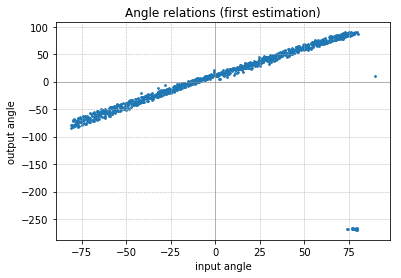

In [114]:
def plot_geometric_angles(input_angles, geometric_angles):

    fig, ax = plt.subplots()
    ax.scatter(input_angles, geometric_angles, s=3)
    ax.grid(True, which='both', linewidth=0.5, linestyle='--')
    ax.axhline(y=0, color='gray', linewidth=0.5)
    ax.axvline(x=0, color='gray', linewidth=0.5)
    ax.set_ylabel('output angle')
    ax.set_xlabel('input angle')
    ax.set_title('Angle relations (first estimation)')
    plt.show()

plot_geometric_angles(data.A, g)

In [115]:
def fit_polynomial_to_data(x_data, y_data, degree):

    coeffs, error, _, _, _ = np.polyfit(x_data, y_data, degree, full=True)
    function = np.poly1d(coeffs)
    x_axis = np.linspace(np.asarray(x_data).min(), np.asarray(x_data).max(), 100)
    print("Koeffizienten: " + str(coeffs))
    print("Relativer Fehler: " + str(error/len(x_data)))

    return function, x_axis

p, xp = fit_polynomial_to_data(data.A, g, 1)


Koeffizienten: [0.86913033 5.08917816]
Relativer Fehler: [1711.0820642]


In die Plot-Funktion wird nun das Ergebnis der linearen Regression eingefügt.

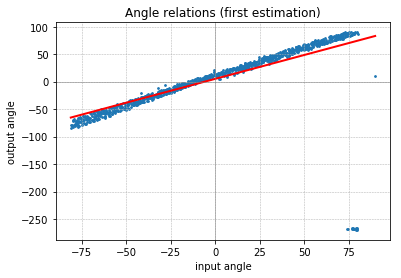

In [116]:
def plot_linear_regression(input_angles, geometric_angles, f, x_axis):
        
    fig, ax = plt.subplots()
    ax.scatter(input_angles, geometric_angles, s=3)
    ax.plot(x_axis, f(x_axis), '-', color='red', linewidth=2)
    ax.grid(True, which='both', linewidth=0.5, linestyle='--')
    ax.axhline(y=0, color='gray', linewidth=0.5)
    ax.axvline(x=0, color='gray', linewidth=0.5)
    ax.set_ylabel('output angle')
    ax.set_xlabel('input angle')
    ax.set_title('Angle relations (first estimation)')
    plt.show()
    
plot_linear_regression(data.A, g, p, xp)


Wie man sieht, ist die Regression noch fehlerbehaftet durch mehrere Ausreißer. Um dies zu beheben, wird eine Funktion benötigt, die die Ausreißer entfernt.

In [117]:
def reject_outliers(input_angles, geometric_angles, f, distance_threshold):
    
    reject_list = []
    for i in range(0, len(input_angles)):
        if np.abs(geometric_angles[i] - f(input_angles[i])) > distance_threshold:
            reject_list.append(i)
    filtered_geometric = np.delete(geometric_angles, reject_list)
    filtered_inputs = np.delete(input_angles, reject_list)
    return filtered_inputs, filtered_geometric

Anschließend wird die Regression mit den gefilterten Datenpunkten erneut ausgeführt und das Ergebnis angezeigt.

Koeffizienten: [ 1.05070577 10.01902907]
Relativer Fehler: [16.77247477]


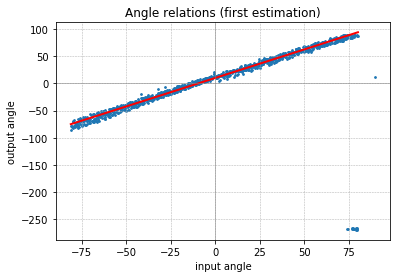

In [118]:
f_inputs, f_geometric = reject_outliers(data.A, g, p, 50)
p, xp = fit_polynomial_to_data(f_inputs, f_geometric, 1)
plot_linear_regression(data.A, g, p, xp)

Aus den Koeffizienten lässt sich folgende lineare Funktion ableiten: 
$δ(α)=10.02∗α+1.05$.

Damit ist der Zusammenhang zwischen Greifwinkel und geometrischem Ablagewinkel (in Polarkoordinaten) bekannt.
Nun fehlt noch eine Berechnung des Radius. Dazu wurde auf Folie 16 ein Zusammenhang zwischen Radius der Ablageposition und der Aufnahmeposition festgestellt. Es wird also eine Funktion r = f(x,y) gesucht. Um zu prüfen, ob sich solch eine Funktion finden lässt, wird der Radius als z-Achse interpretiert und die Punkte werden in einem 3D-Scatterplot (x | y | z) dargestellt.

Zunächst müssen dazu einige Importe durchgeführt werden.

In [119]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Anschließend wird für alle Ablagefehler der Radius berechnet. Dazu wird folgende Funktion definiert:


In [120]:
def calc_radius(dataset):

    radius_list = []

    for i in range(0, dataset.number_of_points):
        radius_list.append(np.sqrt(dataset.dX[i] ** 2 + dataset.dY[i] ** 2))

    return radius_list

Jetzt wird der 3D-Scatterplot eingerichtet und mit Achsenbeschriftungen versehen. Dann wird die Radius-Berechnung für den Datensatz ausgeführt und die Punkte werden im 3D-Scatterplot dargestellt.

In [121]:
def plot_points_3D(dataset):
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(dataset.X, dataset.Y, calc_radius(dataset))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('Output radius')
    fig.show()

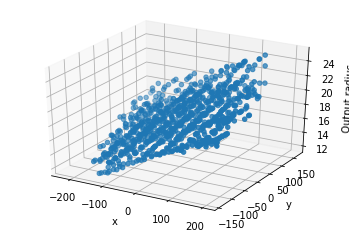

In [122]:
plot_points_3D(data)

Da sich vermuten lässt, dass die Punkte näherungsweise auf einer Ebene liegen, wird im nächsten Schritt mittels linearer Regression eine zweidimensionale lineare Funktion in die Punkte gefittet. Gesucht wird folgende Funktion:
$r = f(x,y) = w_0 + w_1 x + w_2 y$. Demnach sind die Koeffizienten $w_0$, $w_1$ und $w_2$ zu bestimmen. Die zugehörigen Faktoren, welche nötig sind um den Radius zu berechnen, sind $1$, $x$ und $y$. Diese müssen zur Anwendung des Least-Square-Verfahrens mit numpy zunächst für jeden Datenpunkt in einer strukturierten Liste zusammengefasst werden.

In [123]:
def fit_3D_plane(dataset):
    
    r = np.asarray(calc_radius(dataset))
    XY = np.asarray([dataset.X, dataset.Y]).T                               # transpose so input vectors are along the rows
    factors = np.c_[XY, np.ones(XY.shape[0])]                               # add bias term
    coeffs = np.linalg.lstsq(factors, r, rcond=None)[0]
    return coeffs

plane_coefficients = fit_3D_plane(data)

Jetzt kann die berechnete Ebene in den 3D-Plot eingezeichnet werden.

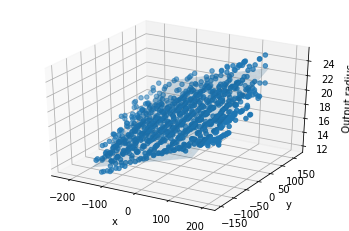

In [124]:
def plot_points_and_plane(dataset, coeffs):
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(dataset.X, data.Y, calc_radius(dataset))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('Output radius')
    
    xx, yy = np.meshgrid(np.arange(-150, 151), np.arange(-150, 151))
    z = (coeffs[0] * xx + coeffs[1] * yy) + coeffs[2]
    ax.plot_surface(xx, yy, z, alpha=0.2)
    
plot_points_and_plane(data, plane_coefficients)

Hier wird auf eine gesonderte Ausreißerbehandlung verzichtet, da die Ebene die Punkte schon relativ gut annähert.
Das heißt also: Es existiert jetzt ein Modell, mit welchem der Radius auf der Output-Seite auf Basis der Aufnahmeposition geschätzt werden kann.


In [125]:
fit_3D_plane(data)

array([1.38399437e-02, 2.05826208e-02, 1.79600949e+01])

Die Zuordnung der Einträge ist wie folgt: $w_1$, $w_2$, $w_0$.
Damit ergibt sich hier folgende Funktion: $f(x,y) = 17.96 + 0.0138 x + 0.02 y $.

Damit kann jetzt die Position des Ablagefehlers geschätzt werden. Nun soll noch die Orientierung des Ablagefehlers untersucht werden. Zwei mögliche Ansätze werden dazu untersucht:

* Abhängigkeit vom Greifwinkel
* Abhängigkeit zum geometrischen Output-Winkel

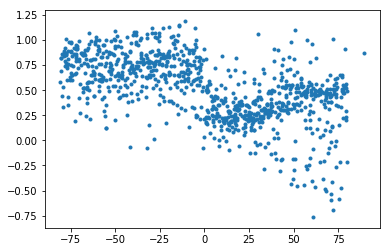

In [126]:
plt.scatter(data.A, data.dA, marker='.')
plt.show()

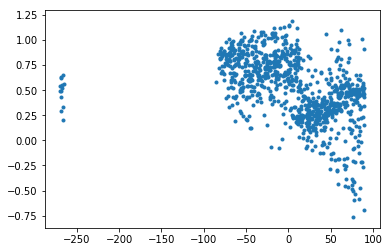

In [127]:
plt.scatter(g, data.dA, marker='.')
plt.show()

Beide Ansätze zeigen keinen jedoch modellierbaren Funktionszusammenhang auf, daher kann (bisher) keine Aussage über den rotatorischen Ablagefehler getroffen werden. Der Vollständigkeit halber wird auch noch eine etwaige Abhängigkeit von der x- und y-Komponente der Greifposition untersucht, auch hier zeigt sich jedoch kein eindeutiger Zusammenhang.

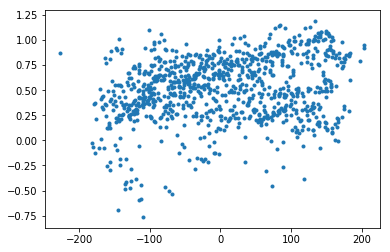

In [128]:
plt.scatter(data.X, data.dA, marker='.')
plt.show()

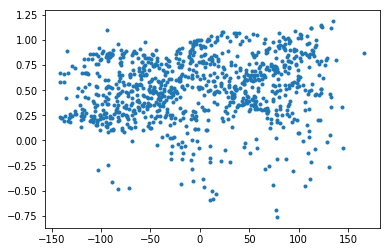

In [129]:
plt.scatter(data.Y, data.dA, marker='.')
plt.show()

## Performance-Analyse

Nun wird für die Positionsschätzung ein mathetisches Modell aufgebaut, dessen Güte anhand der wahren Daten evaluiert werden soll. Ziel ist es nun, den Schätzfehler des Modells zu berechnen. Dazu wird zunächst einmal das berechnete Modell aufgestellt und in eine Funktion zur Schätzung des Modellfehlers integriert.

In [130]:
def calc_model_error(dataset):
    
    deg2rad = np.pi / 180
    w0 = 1.79543597e+01
    w1 = 1.34632446e-02
    w2 = 1.88545630e-02
    
    abs_err = []
    for i in range(0, dataset.number_of_points):
        delta_est = 1.05070577 * dataset.A[i] + 10.01902907
        r_est = w0 + dataset.X[i] * w1 + dataset.Y[i] * w2
        x_est = - r_est * np.sin(delta_est * deg2rad)
        y_est = - r_est * np.cos(delta_est * deg2rad)
        abs_err.append(np.sqrt(np.square(x_est - dataset.dX[i]) + np.square((y_est - dataset.dY[i]))))
    
    return abs_err

In [131]:
def plot_position_error(dataset, title):
    
    abs_err = calc_model_error(dataset)

    plt.plot(abs_err)
    plt.title(title)
    plt.grid(True, which='both', linewidth=0.5, linestyle='--')
    axes = plt.gca()
    axes.set_ylim([-1, 27])
    fig = plt.gcf()
    fig.set_size_inches(12, 2.5, forward=True)
    plt.show()

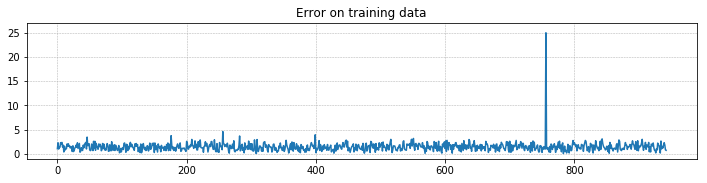

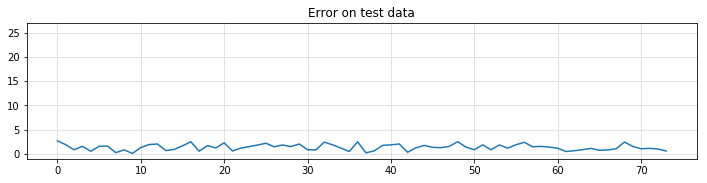

In [132]:
train_data = Dataset()
train_data.read_data('dataset/kapace_training.csv', 1)

test_data = Dataset()
test_data.read_data('dataset/kapace_test.csv', 1)

plot_position_error(train_data, 'Error on training data')
plot_position_error(test_data,'Error on test data')

In [133]:
def calc_error_measures(dataset):
    
    abs_err = calc_model_error(dataset)
        
    mae = np.mean(np.asarray(abs_err)).round(2)
    var = np.var(np.asarray(abs_err)).round(2)
    max_err = np.max(abs_err).round(2)
    return [mae, max_err, var]

In [134]:
[mae, max_err, var] = calc_error_measures(train_data)

In [135]:
print("Fehler Trainingsdaten:")
print("mae = " + str(mae))
print("max = " + str(max_err))
print("var = " + str(var))


Fehler Trainingsdaten:
mae = 1.45
max = 24.96
var = 1.05


In [136]:
[mae, max_err, var] = calc_error_measures(test_data)

In [137]:
print("Fehler Testdaten:")
print("mae = " + str(mae))
print("max = " + str(max_err))
print("var = " + str(var))

Fehler Testdaten:
mae = 1.37
max = 2.71
var = 0.39
